# Importing functions

In [110]:
import pandas as pd 
import numpy as np
import pandasql as ps
import os
import re
import joblib
import random 
import numpy as np
import warnings
import tensorflow as tf 
from imblearn.over_sampling import RandomOverSampler
from sklearn.compose import make_column_transformer
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from preprocess_days_stats import preprocess_match_days
from preprocess_time_serie import preprocess_teams, create_time_series_features
from preprocess_time_series_features import preprocess_features_time_series, create_fast_preprocessing_ts, preprocess_features_time_series_odds, create_fast_preprocessing_ts_odds
from helper_functions_tensorflow import CSVLoggerCallback, CSVLoggerCallbackParams
from Data_scraping.odds_scraping import refresh_odds

# Ignora tutti i warning temporaneamente
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

today_date = '2023-12-16'
start_date_filter = '15/12'
end_date_filter = '18/12'
refresh_odds(start_date_filter,end_date_filter)

Cookie popup not found or encountered an error: Message: 
Stacktrace:
	GetHandleVerifier [0x00007FF7AD1C82B2+55298]
	(No symbol) [0x00007FF7AD135E02]
	(No symbol) [0x00007FF7ACFF05AB]
	(No symbol) [0x00007FF7AD03175C]
	(No symbol) [0x00007FF7AD0318DC]
	(No symbol) [0x00007FF7AD06CBC7]
	(No symbol) [0x00007FF7AD0520EF]
	(No symbol) [0x00007FF7AD06AAA4]
	(No symbol) [0x00007FF7AD051E83]
	(No symbol) [0x00007FF7AD02670A]
	(No symbol) [0x00007FF7AD027964]
	GetHandleVerifier [0x00007FF7AD540AAB+3694587]
	GetHandleVerifier [0x00007FF7AD59728E+4048862]
	GetHandleVerifier [0x00007FF7AD58F173+4015811]
	GetHandleVerifier [0x00007FF7AD2647D6+695590]
	(No symbol) [0x00007FF7AD140CE8]
	(No symbol) [0x00007FF7AD13CF34]
	(No symbol) [0x00007FF7AD13D062]
	(No symbol) [0x00007FF7AD12D3A3]
	BaseThreadInitThunk [0x00007FF9F64E257D+29]
	RtlUserThreadStart [0x00007FF9F75AAA58+40]

HTML saved to Data_scraping/last_odds.html
['1.67', '2.10', '2.35', '1.55', '1.80', '3.30', '5.00']
['2.00', '1.73', '1.92', '1

In [111]:
def preprocess_features_time_series_odds_preds(df_Serie_A, num_features, today_date):

    all_features = ['ft_goals','ft_goals_conceded','shots','shots_target', 'fouls_done','corners_obtained', 'yellows', 'reds']
    less_features = ['ft_goals','ft_goals_conceded','shots', 'fouls_done','corners_obtained', 'reds']
    few_features = ['ft_goals','ft_goals_conceded','shots', 'reds']

    Train_df = df_Serie_A.iloc[:10]
    Valid_df = df_Serie_A.iloc[:10]
    Test_df = df_Serie_A[df_Serie_A['date']==today_date]

    Train_labels = Train_df[['ft_result']]
    Valid_labels = Valid_df[['ft_result']]
    Test_labels = Test_df[['ft_result']]
    
    Train_odds = Train_df[['home_win_odds','draw_odds','away_win_odds']]
    Valid_odds = Valid_df[['home_win_odds','draw_odds','away_win_odds']]
    Test_odds = Test_df[['home_win_odds','draw_odds','away_win_odds']]

    # preprocess Train dataframe
    Train_teams = Train_df[['stagione','hometeam','awayteam']]

    if num_features == 'all':
        features = all_features
        print('utilizzando tutte le features')
    elif num_features == 'less':
        print('utilizzando meno features')
        features = less_features
    else:
        print('utilizzando poche features')
        features=few_features

    Train_dict_features={}

    for feature in features:
        Train_dict_features[feature] = pd.DataFrame({})
        for colonna in Train_df.columns:
            pattern = re.compile(rf'^home_{feature}_\d+$')
            if pattern.match(colonna):
                Train_dict_features[feature][colonna]=Train_df[colonna]
        for colonna in Train_df.columns:
            pattern = re.compile(rf'^away_{feature}_\d+$')
            if pattern.match(colonna):
                Train_dict_features[feature][colonna]=Train_df[colonna]

    #preprocess valid dataframe
    Valid_teams = Valid_df[['stagione','hometeam','awayteam']]


    if num_features == 'all':
        features = all_features
        print('utilizzando tutte le features')
    elif num_features == 'less':
        print('utilizzando meno features')
        features = less_features
    else:
        print('utilizzando poche features')
        features=few_features

    Valid_dict_features={}

    for feature in features:
        Valid_dict_features[feature] = pd.DataFrame({})
        for colonna in Valid_df.columns:
            pattern = re.compile(rf'^home_{feature}_\d+$')
            if pattern.match(colonna):
                Valid_dict_features[feature][colonna]=Valid_df[colonna]
        for colonna in Valid_df.columns:
            pattern = re.compile(rf'^away_{feature}_\d+$')
            if pattern.match(colonna):
                Valid_dict_features[feature][colonna]=Valid_df[colonna]

    # preprocess test dataframe
    Test_teams = Test_df[['stagione','hometeam','awayteam']]

    if num_features == 'all':
        features = all_features
        print('utilizzando tutte le features')
    elif num_features == 'less':
        print('utilizzando meno features')
        features = less_features
    else:
        print('utilizzando poche features')
        features=few_features

    Test_dict_features={}

    for feature in features:
        Test_dict_features[feature] = pd.DataFrame({})
        for colonna in Test_df.columns:
            pattern = re.compile(rf'^home_{feature}_\d+$')
            if pattern.match(colonna):
                Test_dict_features[feature][colonna]=Test_df[colonna]
        for colonna in Test_df.columns:
            pattern = re.compile(rf'^away_{feature}_\d+$')
            if pattern.match(colonna):
                Test_dict_features[feature][colonna]=Test_df[colonna]

    #encoding teams
    # load the  transformer
    teams_transf = joblib.load('transformers/teams_transformer.pkl')

    Train_teams_encoded = teams_transf.transform(Train_teams)
    Valid_teams_encoded = teams_transf.transform(Valid_teams)
    Test_teams_encoded = teams_transf.transform(Test_teams)

    #encoding labels
    # load the  transformer
    ordinal_encoder = joblib.load('transformers/ordinal_encoder_transformer.pkl')

    Train_labels_encoded = np.squeeze(ordinal_encoder.transform(np.array(Train_labels).reshape(-1, 1)))
    Valid_labels_encoded = np.squeeze(ordinal_encoder.transform(np.array(Valid_labels).reshape(-1, 1)))
    Test_labels_encoded = np.squeeze(ordinal_encoder.transform(np.array(Test_labels).reshape(-1, 1)))  

    #encoding numerical features
    Train_dict_features_norm = Train_dict_features.copy()
    Valid_dict_features_norm = Valid_dict_features.copy()
    Test_dict_features_norm = Test_dict_features.copy()

    for feature in list(Train_dict_features.keys()):
        # load the  transformer
        numerical_transf = joblib.load(f'transformers/numerical_{feature}_transformer.pkl')

        Train_dict_features_norm[feature] = numerical_transf.transform(Train_dict_features_norm[feature])
        Valid_dict_features_norm[feature] = numerical_transf.transform(Valid_dict_features_norm[feature])
        Test_dict_features_norm[feature] = numerical_transf.transform(Test_dict_features_norm[feature])
    
    # Encoding odds
    # load the  transformer
    odds_transf = joblib.load('transformers/odds_transformer.pkl')

    Train_odds_norm = odds_transf.transform(Train_odds)
    Valid_odds_norm = odds_transf.transform(Valid_odds)
    Test_odds_norm = odds_transf.transform(Test_odds)

    return (Train_teams_encoded, Valid_teams_encoded, Test_teams_encoded, Train_labels_encoded, Valid_labels_encoded, Test_labels_encoded, 
            Train_dict_features_norm, Valid_dict_features_norm, Test_dict_features_norm, Train_teams, Valid_teams, Test_teams, Train_labels, Valid_labels, Test_labels, 
            Train_dict_features, Valid_dict_features, Test_dict_features, Train_df, Valid_df, Test_df, 
            Train_odds_norm, Valid_odds_norm, Test_odds_norm)

# Obtaining the new odds

In [112]:
import re
import pandas as pd

column_types = {'1': float, 'x': float, '2': float}
last_odds = pd.read_csv(r'Data_scraping/last_odds.csv', dtype=column_types)

# Adding the new results to the dataframe

In [113]:
# Leggi il file CSV
df = pd.read_csv(r"C:\Users\Hp\Serie_A\csv_predictions\stagione_23_24.csv", parse_dates=['Date'], dayfirst=True)
df = df[df['Date'] != today_date]

# Crea un DataFrame con 10 righe di zeri
new_rows = pd.DataFrame(0, index=range(10), columns=df.columns)

# # Assegna valori specifici alle colonne 'Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam' per ciascuna riga
# new_rows.loc[0, ['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']] = ['I1', f'{today_date}', '17:30', 'Juventus', 'Napoli',0,0,'D']
# new_rows.loc[1, ['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']] = ['I1', f'{today_date}', '17:30', 'Verona', 'Lazio',0,0,'D']
# new_rows.loc[2, ['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']] = ['I1', f'{today_date}', '17:30', 'Atalanta', 'Milan',0,0,'D']
# new_rows.loc[3, ['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']] = ['I1', f'{today_date}', '17:30', 'Inter', 'Udinese',0,0,'D']
# new_rows.loc[4, ['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']] = ['I1', f'{today_date}', '17:30', 'Frosinone', 'Torino',0,0,'D']
# new_rows.loc[5, ['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']] = ['I1', f'{today_date}', '17:30', 'Monza', 'Genoa',0,0,'D']
# new_rows.loc[6, ['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']] = ['I1', f'{today_date}', '17:30', 'Salernitana', 'Bologna',0,0,'D']
# new_rows.loc[7, ['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']] = ['I1', f'{today_date}', '17:30', 'Roma', 'Fiorentina',0,0,'D']
# new_rows.loc[8, ['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']] = ['I1', f'{today_date}', '17:30', 'Empoli', 'Lecce',0,0,'D']
# new_rows.loc[9, ['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']] = ['I1', f'{today_date}', '17:30', 'Cagliari', 'Sassuolo',0,0,'D']

new_rows.loc[0, ['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']] = ['I1', f'{today_date}', '17:30', 'Genoa', 'Juventus',0,0,'D']
new_rows.loc[1, ['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']] = ['I1', f'{today_date}', '17:30', 'Lecce', 'Frosinone',0,0,'D']
new_rows.loc[2, ['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']] = ['I1', f'{today_date}', '17:30', 'Napoli', 'Cagliari',0,0,'D']
new_rows.loc[3, ['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']] = ['I1', f'{today_date}', '17:30', 'Torino', 'Empoli',0,0,'D']
new_rows.loc[4, ['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']] = ['I1', f'{today_date}', '17:30', 'Milan', 'Monza',0,0,'D']
new_rows.loc[5, ['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']] = ['I1', f'{today_date}', '17:30', 'Fiorentina', 'Verona',0,0,'D']
new_rows.loc[6, ['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']] = ['I1', f'{today_date}', '17:30', 'Udinese', 'Sassuolo',0,0,'D']
new_rows.loc[7, ['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']] = ['I1', f'{today_date}', '17:30', 'Bologna', 'Roma',0,0,'D']
new_rows.loc[8, ['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']] = ['I1', f'{today_date}', '17:30', 'Lazio', 'Inter',0,0,'D']
new_rows.loc[9, ['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']] = ['I1', f'{today_date}', '17:30', 'Atalanta', 'Salernitana',0,0,'D']

#inserisco le nuove quote
i=0
for index, row in last_odds.iterrows():
    win, draw, loss = row
    new_rows.loc[i,['B365H', 'B365D', 'B365A']] = [win,draw,loss]
    i=i+1

# new_rows.loc[0,['B365H', 'B365D', 'B365A']] = [4.75, 3.25, 1.85]
# new_rows.loc[1,['B365H', 'B365D', 'B365A']] = [2.05, 3.35, 3.6]
# new_rows.loc[2,['B365H', 'B365D', 'B365A']] = [1.3, 5.5, 9.0]
# new_rows.loc[3,['B365H', 'B365D', 'B365A']] = [1.55, 4.0, 6.0]
# new_rows.loc[4,['B365H', 'B365D', 'B365A']] = [1.55, 4.25, 5.75]
# new_rows.loc[5,['B365H', 'B365D', 'B365A']] = [1.45, 4.5, 6.5]
# new_rows.loc[6,['B365H', 'B365D', 'B365A']] = [2.25, 3.5, 3.05]
# new_rows.loc[7,['B365H', 'B365D', 'B365A']] = [2.35, 3.0, 3.3]
# new_rows.loc[8,['B365H', 'B365D', 'B365A']] = [4.75, 3.7, 1.73]
# new_rows.loc[9,['B365H', 'B365D', 'B365A']] = [1.3, 5.5, 8.75]

# Aggiungi le nuove righe al DataFrame esistente
new_csv = pd.concat([df, new_rows], ignore_index=True)
new_csv['Date'] = pd.to_datetime(new_csv['Date'], format='%Y-%m-%d')

# Salva il DataFrame aggiornato su un nuovo file CSV
new_csv.to_csv(r"C:\Users\Hp\Serie_A\csv_predictions\stagione_23_24.csv")

len(new_csv['HomeTeam'].unique()), len(new_csv['AwayTeam'].unique())


(20, 20)

In [114]:
#preprocess the data
df_giornate = preprocess_match_days(r"C:\Users\Hp\Serie_A\csv_predictions")
num_features = 'less'
num_giornate = 4
Statistiche_squadre_dict = preprocess_teams(dataframe = df_giornate)
df_Serie_A = create_time_series_features(num_features, Statistiche_squadre_dict, df_giornate, num_giornate).dropna()

(Train_teams_encoded, Valid_teams_encoded, Test_teams_encoded, Train_labels_encoded, Valid_labels_encoded, Test_labels_encoded, 
    Train_dict_features_norm, Valid_dict_features_norm, Test_dict_features_norm, Train_teams, Valid_teams, Test_teams, Train_labels, Valid_labels, 
    Test_labels, Train_dict_features, Valid_dict_features, Test_dict_features, Train_df, Valid_df, Test_df, 
    Train_odds_norm, Valid_odds_norm, Test_odds_norm) = preprocess_features_time_series_odds_preds(df_Serie_A, num_features, today_date)

feature_input_shape = Test_dict_features_norm[list(Test_dict_features_norm.keys())[0]].shape[1]
Train_teams_shape = Test_teams_encoded.shape[1]

Dataset_train_norm, Dataset_valid_norm, Dataset_test_norm = create_fast_preprocessing_ts_odds(Train_teams_encoded, Train_dict_features_norm, Train_labels_encoded,
                                                                                         Valid_teams_encoded, Valid_dict_features_norm,
                                                                    Valid_labels_encoded,Test_teams_encoded, Test_dict_features_norm, Test_labels_encoded, 
                                                                    Train_odds_norm, Valid_odds_norm, Test_odds_norm)

Reading file: I1 (0).csv
Reading file: I1 (1).csv
Reading file: I1 (10).csv
Reading file: I1 (11).csv
Reading file: I1 (12).csv
Reading file: I1 (13).csv
Reading file: I1 (14).csv
Reading file: I1 (15).csv
Reading file: I1 (16).csv
Reading file: I1 (17).csv


Reading file: I1 (2).csv
Reading file: I1 (3).csv
Reading file: I1 (4).csv
Reading file: I1 (5).csv
Reading file: I1 (6).csv
Reading file: I1 (7).csv
Reading file: I1 (8).csv
Reading file: I1 (9).csv
Reading file: stagione_23_24.csv
preprocessing finished!
utilizzando meno features
preprocess finished
utilizzando meno features
utilizzando meno features
utilizzando meno features


In [115]:
#import the model 
odds_model = tf.keras.models.load_model(r'c:\Users\Hp\Serie_A\model_experiments\model_odds_time_series')


In [116]:
from datetime import datetime

## Visualizziamo un po' di risultati 
model_odds_new_pred_probs = odds_model.predict((Dataset_test_norm))
model_odds_new_prob = model_odds_new_pred_probs.max(axis=1)
model_odds_new_predictions = model_odds_new_pred_probs.argmax(axis=1)
model_odds_new_compare = pd.DataFrame({
                                'hometeam': list( Test_df['hometeam'] ),
                                'awayteam': list( Test_df['awayteam'] ),
                                'preds': model_odds_new_predictions, 
                                'best_pred_prob': model_odds_new_prob,
                                })

model_odds_new_compare[['model_away_prob','model_draw_prob','model_home_prob']] = model_odds_new_pred_probs
model_odds_new_compare[['home_win_odds', 'draw_odds', 'away_win_odds']] = Test_df[['home_win_odds', 'draw_odds', 'away_win_odds']].values
model_odds_new_compare['snai_pred'] = np.argmin(Test_df[['home_win_odds', 'draw_odds', 'away_win_odds']].fillna(0.0).to_numpy(), axis=1)
model_odds_new_compare['snai_prob'] = np.nanmin(Test_df[['home_win_odds', 'draw_odds', 'away_win_odds']].fillna(0.0).to_numpy(), axis=1)

# Assegno ai valori encoded dei valori più comprensibili per vittoria pareggio sconfitta
conditions = [
(model_odds_new_compare['preds'] == 2),  # Condizione per Home Win
(model_odds_new_compare['preds'] == 0),  # Condizione per Away Win
(model_odds_new_compare['preds'] == 1)   # Condizione per draw
]
conditions_snai = [
(model_odds_new_compare['snai_pred'] == 0),  # Condizione per Home Win
(model_odds_new_compare['snai_pred'] == 2),  # Condizione per Away Win
(model_odds_new_compare['snai_pred'] == 1)   # Condizione per Draw
]
# Valori corrispondenti alle condizioni
values = ['H', 'A', 'D']

# Creazione della nuova colonna 'result' e 'points
model_odds_new_compare['preds'] = np.select(conditions, values)
model_odds_new_compare['snai_pred'] = np.select(conditions_snai, values)
model_odds_new_compare['money_won'] = model_odds_new_compare['best_pred_prob']*model_odds_new_compare['snai_prob']

# creo la colonna money won 
model_odds_new_compare['pred_odds'] = model_odds_new_compare.apply(lambda row: row['home_win_odds'] if row['preds'] == 'H' else (row['draw_odds'] if row['preds'] == 'D' 
                                                                                             else row['away_win_odds']), axis=1)
# Inserisci la colonna nella nuova posizione
insert_data = model_odds_new_compare['money_won']
model_odds_new_compare.drop(columns=['money_won'], inplace=True)
model_odds_new_compare.insert(4, 'money_won', insert_data)
print(f'\n ultima esecuzione : {datetime.now()}')

1/1 [==============================] - 0s 395ms/step

 ultima esecuzione : 2023-12-12 21:54:47.123835


In [117]:
model_odds_new_compare

,hometeam,awayteam,preds,best_pred_prob,money_won,model_away_prob,model_draw_prob,model_home_prob,home_win_odds,draw_odds,away_win_odds,snai_pred,snai_prob,pred_odds
0,Lecce,Frosinone,H,0.367370,0.771476,0.308650,0.323980,0.367370,2.10,3.30,3.55,H,2.10,2.10
1,Napoli,Cagliari,H,0.713256,0.927233,0.089408,0.197336,0.713256,1.30,5.50,9.00,H,1.30,1.30
2,Milan,Monza,H,0.601250,0.931938,0.155873,0.242877,0.601250,1.55,4.25,5.75,H,1.55,1.55
3,Lazio,Inter,A,0.552648,0.956081,0.552648,0.257109,0.190243,4.75,3.70,1.73,A,1.73,1.73
4,Torino,Empoli,H,0.500757,0.801211,0.203756,0.295487,0.500757,1.60,3.90,5.75,H,1.60,1.60
5,Fiorentina,Verona,H,0.640063,0.928091,0.126136,0.233801,0.640063,1.45,4.50,6.75,H,1.45,1.45
6,Bologna,Roma,H,0.389764,0.935434,0.298928,0.311308,0.389764,2.40,3.00,3.25,H,2.40,2.40
7,Atalanta,Salernitana,H,0.625692,0.813399,0.123481,0.250828,0.625692,1.30,5.50,9.25,H,1.30,1.30
8,Genoa,Juventus,A,0.556978,1.002560,0.556978,0.256895,0.186127,5.00,3.30,1.80,A,1.80,1.80
9,Udinese,Sassuolo,H,0.400832,0.901871,0.282521,0.316648,0.400832,2.25,3.50,3.05,H,2.25,2.25


In [118]:
import csv
with open('predictions_variations.csv', mode='a', newline='', encoding='utf-8',) as file:
    csv_writer = csv.writer(file)
    print(os.path.getsize('predictions_variations.csv'))
    if os.path.getsize('predictions_variations.csv') == 0:
        csv_writer.writerow(list(model_odds_new_compare['hometeam']) + ['Date'])
    csv_writer.writerow(list(model_odds_new_compare['money_won']) + [str(datetime.now().strftime("%d/%m/%y-%H:%M"))])

488


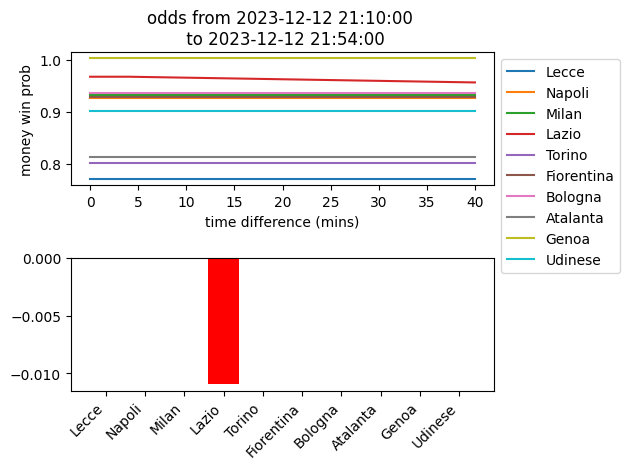

In [119]:
import matplotlib.pyplot as plt
predict_variations = pd.read_csv(r'predictions_variations.csv', parse_dates=['Date'])

tempi = [(list(predict_variations['Date'])[i+1] - list(predict_variations['Date'])[i]).total_seconds() / 60 for i in range(len(predict_variations)-1)]
tempi.insert(0, 0)

plt.subplot(2,1,1)
for squadra in predict_variations.columns[:-1]:
    plt.plot(tempi, predict_variations[squadra])

plt.legend(predict_variations.columns[:-1], bbox_to_anchor=(1, 1))
plt.xlabel('time difference (mins)')
plt.ylabel('money win prob')
plt.title(f"odds from {list(predict_variations['Date'])[0]} \n to {list(predict_variations['Date'])[len(predict_variations)-1]}")

plt.plot()
# create histogram
plt.subplot(2,1,2)
differenza_ultima_penultima = predict_variations[predict_variations.columns[:-1]].diff().iloc[-1]
colori = ['green' if num > 0 else 'red' for num in differenza_ultima_penultima]
plt.bar(predict_variations.columns[:-1], differenza_ultima_penultima, color=colori)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [121]:
predict_variations

,Lecce,Napoli,Milan,Lazio,Torino,Fiorentina,Bologna,Atalanta,Genoa,Udinese,Date
0,0.771476,0.927233,0.931938,0.967025,0.801211,0.928091,0.935434,0.813399,1.00256,0.901871,2023-12-12 21:10:00
1,0.771476,0.927233,0.931938,0.967025,0.801211,0.928091,0.935434,0.813399,1.00256,0.901871,2023-12-12 21:14:00
2,0.771476,0.927233,0.931938,0.956081,0.801211,0.928091,0.935434,0.813399,1.00256,0.901871,2023-12-12 21:54:00
